In [144]:
import requests
import polars as pl
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import ttest_ind
import numpy as np
import time

### 1. Для сбора данных был выбран CoinGecko, а точнее GeckoTerminal. 
### Было желание потыкать The Graph для on-chain данных, но бесплатной версии для демки там не было. 

In [145]:
request_count = 0
def get_price_data(pool_address='58oQChx4yWmvKdwLLZzBi4ChoCc2fqCUWBkwMihLYQo2', timeframe='minute', limit=1000):
    global request_count
    url = f"https://api.geckoterminal.com/api/v2/networks/solana/pools/{pool_address}/ohlcv/{timeframe}?limit={limit}"
    print(f"Запрос: {url}")
    
    try:
        response = requests.get(url, timeout=10)
        request_count += 1
        print(f"Запрос #{request_count}, статус: {response.status_code}")
        
        if response.status_code != 200:
            print(f"Ошибка API: {response.text}")
            raise Exception(f"Статус {response.status_code}")
        
        data = response.json()
        if 'data' not in data or not data['data']['attributes']['ohlcv_list']:
            raise ValueError("Данные пусты")
        
        ohlcv = data['data']['attributes']['ohlcv_list']
        df = pl.DataFrame({
            'timestamp': [row[0] * 1000 for row in ohlcv],  # Перевод секунд в миллисекунды
            'high': [row[2] for row in ohlcv],
            'low': [row[3] for row in ohlcv],
            'price': [row[4] for row in ohlcv],  # close price
            'volume': [row[5] for row in ohlcv]
        })
        df = df.with_columns(pl.col('timestamp').cast(pl.Int64).cast(pl.Datetime('ms')))
        return df
    except Exception as e:
        print(f"Ошибка: {e}")
        return None

In [146]:
df = get_price_data()

Запрос: https://api.geckoterminal.com/api/v2/networks/solana/pools/58oQChx4yWmvKdwLLZzBi4ChoCc2fqCUWBkwMihLYQo2/ohlcv/minute?limit=1000
Запрос #1, статус: 200


### 2.Данные берутся с пула SOL/USDC за 1 день, считаем метрики volatility, avg_spread, slippage, market_depth, impact, результаты визуализируются

In [147]:
def calculate_metrics(df):
    # Волатильность, стандартное отклонение доходности
    df = df.with_columns(
        pl.col("price").pct_change().alias("returns")
    )
    volatility = df["returns"].std()
    print(f"Волатильность (std доходности): {volatility:.6f}")

    # Спред, средняя разница high/low
    if "high" in df and "low" in df:
        df = df.with_columns(
            (pl.col("high") - pl.col("low")).alias("spread")
        )
        avg_spread = df["spread"].mean()
        print(f"Средний спред (high-low): {avg_spread:.6f}")
    else:
        avg_spread = None
        print("Спред не рассчитан: нужны high/low")

    # Проскальзывание, изменение цены при большом объёме. Тут поставил трешхолд 0.9, думал насчёт 0.95
    high_volume_threshold = df["volume"].quantile(0.9)
    df = df.with_columns(
        pl.col("volume").gt(high_volume_threshold).alias("high_volume")
    )
    slippage = df.filter(pl.col("high_volume"))["returns"].abs().mean()
    print(f"Среднее проскальзывание (при высоком объёме): {slippage:.6f}")

    # Глубина рынка, средний объём за 5 минут
    market_depth = df["volume"].mean()
    print(f"Средняя глубина рынка (объём): {market_depth:.2f} USD")

    # Влияние крупных транзакций, корреляция объёма и модуля доходности
    impact = df.select(pl.corr("volume", pl.col("returns").abs())).item()
    print(f"Влияние транзакций (корреляция объёма и |доходности|): {impact:.6f}")

    return df, {
        "volatility": volatility,
        "avg_spread": avg_spread,
        "slippage": slippage,
        "market_depth": market_depth,
        "impact": impact
    }

# Визуализация метрик
def visualize_metrics(df, metrics):
    plt.figure(figsize=(12, 8))

    # График цен и объёмов
    plt.subplot(2, 1, 1)
    plt.plot(df["timestamp"], df["price"], label="Цена SOL/USDC", color="blue")
    plt.ylabel("Цена (USD)")
    plt.legend(loc="upper left")
    plt.grid()
    plt.title("Цены и метрики SOL/USDC")

    plt.twinx()
    plt.plot(df["timestamp"], df["volume"], label="Объём (USD)", color="orange", alpha=0.5)
    plt.ylabel("Объём (USD)")
    plt.legend(loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(df["timestamp"], df["spread"], label="Спред (high-low)", color="green")
    plt.ylabel("Спред (USD)")
    plt.xlabel("Время")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()



Волатильность (std доходности): 0.001580
Средний спред (high-low): 0.337460
Среднее проскальзывание (при высоком объёме): 0.002044
Средняя глубина рынка (объём): 30865.53 USD
Влияние транзакций (корреляция объёма и |доходности|): 0.256569


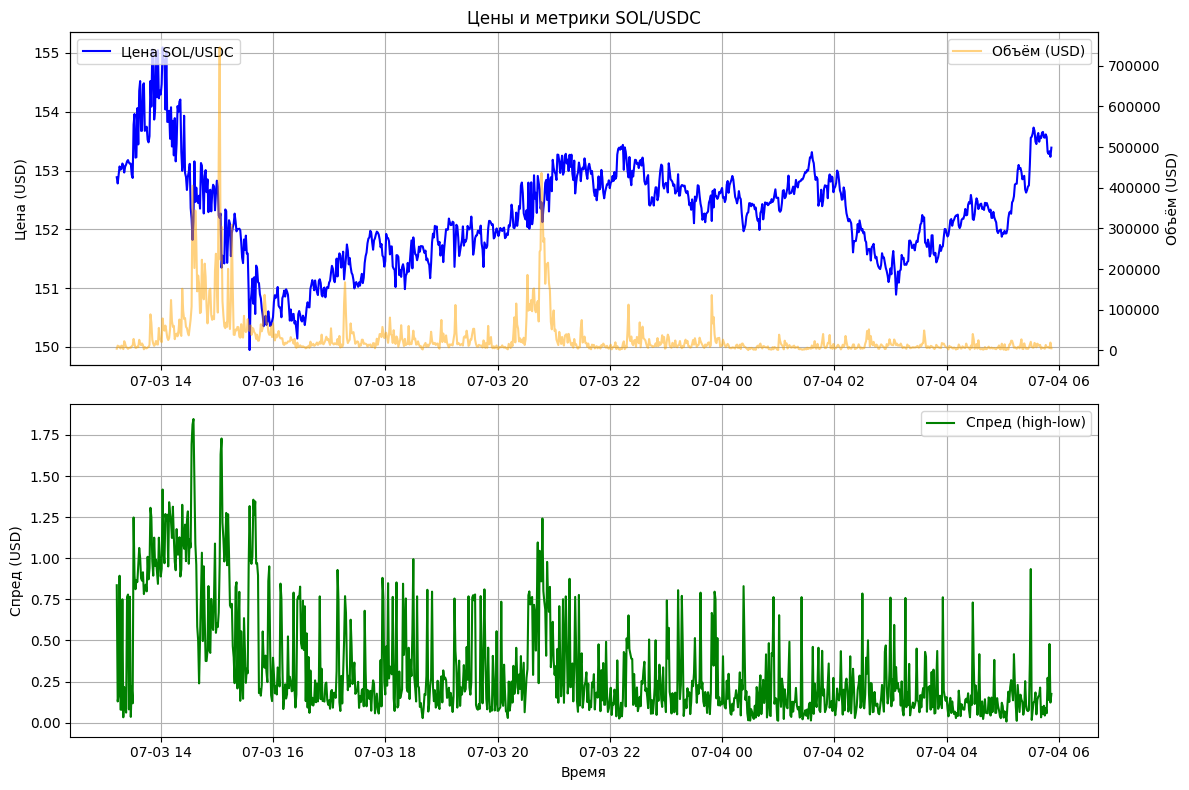


Итоговые метрики:
volatility: 0.0015797894601940594
avg_spread: 0.3374602051729071
slippage: 0.0020440396255810202
market_depth: 30865.525584502593
impact: 0.2565687284354243


In [148]:
try:
    df, metrics = calculate_metrics(df)
    visualize_metrics(df, metrics)
    
    print("\nИтоговые метрики:")
    for key, value in metrics.items():
        print(f"{key}: {value if value is not None else 'N/A'}")
except Exception as e:
    print(f"Ошибка: {e}")


### 3. Реализуем простейшую стратегию и произведем её backtest на данных за 30 дней. Покупку производим при "аномалиях", то есть, в данном случае, когда крайне высокий объем (90 прецентиль), либо при падение цены более чем на 2%

In [157]:
request_count = 0
def get_price_data_30_days(pool_address='58oQChx4yWmvKdwLLZzBi4ChoCc2fqCUWBkwMihLYQo2', timeframe='minute', days=30):
    global request_count
    limit = 1000  # Максимум точек за запрос
    all_data = []
    end_time = int(datetime.now().timestamp())
    start_time = int((datetime.now() - timedelta(days=days)).timestamp())
    
    # Вручную тут ввел ограничение на количество запросов, т.к. получал rate limit на 31 запросе
    i = 0
    while end_time > start_time and i < 30:
        i += 1
        url = f"https://api.geckoterminal.com/api/v2/networks/solana/pools/{pool_address}/ohlcv/{timeframe}?limit={limit}&before_timestamp={end_time}"
        try:
            response = requests.get(url, timeout=10)
            request_count += 1
            if response.status_code != 200:
                print(f"Ошибка API: {response.text}")
                return None
            data = response.json()
            if 'data' not in data or not data['data']['attributes']['ohlcv_list']:
                print("Данные пусты")
                return None
            ohlcv = data['data']['attributes']['ohlcv_list']
            all_data.extend(ohlcv)
            end_time = ohlcv[-1][0] - 1  # Следующий запрос до последнего timestamp
        except Exception as e:
            print(f"Ошибка: {e}")
            return None

    df = pl.DataFrame({
        'timestamp': [row[0] * 1000 for row in all_data],
        'price': [row[4] for row in all_data],
        'volume': [row[5] for row in all_data]
    })
    df = df.with_columns(pl.col('timestamp').cast(pl.Int64).cast(pl.Datetime('ms')))
    return df.sort('timestamp')

In [163]:
### Для простоты позиции в стратегиях везде 1000$

In [150]:
def trading_strategy(df, volume_threshold=0.9, price_drop_threshold=-0.02, target_profit=0.02, fee=0.0025, gas=0.01):
    df = df.with_columns(
        pl.col('volume').quantile(volume_threshold).alias('volume_threshold'),
        pl.col('price').pct_change().alias('price_change')
    )
    #print(df)
    trades = []
    position = None
    for i in range(1, len(df)):
        if position is None:  # Ищем точку входа
            if (df['volume'][i] > df['volume_threshold'][0] or 
                df['price_change'][i] <= price_drop_threshold):
                position = {
                    'entry_price': df['price'][i],
                    'entry_time': df['timestamp'][i],
                    'size': 1000 / df['price'][i]  # Покупаем на $1000
                }
        elif position:  # Проверяем выход
            current_price = df['price'][i]
            profit = (current_price - position['entry_price']) / position['entry_price']
            if profit >= target_profit or profit <= -0.05:  # Выход по прибыли или стоп-лоссу
                exit_price = current_price
                trade_value = position['size'] * exit_price
                total_fee = (position['size'] * position['entry_price'] * fee + 
                            trade_value * fee + gas * 2)
                pnl = trade_value - position['size'] * position['entry_price'] - total_fee
                trades.append({
                    'entry_time': position['entry_time'],
                    'exit_time': df['timestamp'][i],
                    'entry_price': position['entry_price'],
                    'exit_price': exit_price,
                    'pnl': pnl,
                    'success': pnl > 0
                })
                position = None
    
    trades_df = pl.DataFrame(trades)
    return trades_df

In [158]:
def analyze_trades(trades_df):
    total_trades = len(trades_df)
    success_rate = trades_df['success'].mean() if total_trades > 0 else 0
    total_pnl = trades_df['pnl'].sum() if total_trades > 0 else 0
    print(f"Всего сделок: {total_trades}")
    print(f"Процент успешных сделок: {success_rate * 100:.2f}%")
    print(f"Общий PnL: {total_pnl:.2f} USD")
    return {
        'total_trades': total_trades,
        'success_rate': success_rate,
        'total_pnl': total_pnl
    }

In [159]:
def visualize_trades(trades_df):
    if trades_df.is_empty():
        print("Нет сделок для визуализации")
        return
    plt.figure(figsize=(10, 5))
    plt.plot(trades_df['exit_time'], trades_df['pnl'].cum_sum(), label='Кумулятивный PnL', color='blue')
    plt.title('Кумулятивный PnL стратегии')
    plt.xlabel('Время')
    plt.ylabel('PnL (USD)')
    plt.grid()
    plt.legend()
    plt.show()

In [153]:
try:
    df = get_price_data_30_days(pool_address='58oQChx4yWmvKdwLLZzBi4ChoCc2fqCUWBkwMihLYQo2')
    if df is None:
        raise Exception("Не удалось загрузить данные")
except Exception as e:
    print(f"Ошибка: {e}")

In [160]:
df

timestamp,price,volume
datetime[ms],f64,f64
2025-06-05 11:35:00,151.848384,517.250938
2025-06-05 11:37:00,151.848402,16.056644
2025-06-05 11:39:00,151.847628,333.164895
2025-06-05 11:40:00,151.863608,16.790753
2025-06-05 11:42:00,151.863608,0.270775
…,…,…
2025-07-04 05:48:00,153.315198,7677.231293
2025-07-04 05:49:00,153.282903,7710.637604
2025-07-04 05:50:00,153.328664,5473.98477


Всего сделок: 15
Процент успешных сделок: 60.00%
Общий PnL: 81.11 USD


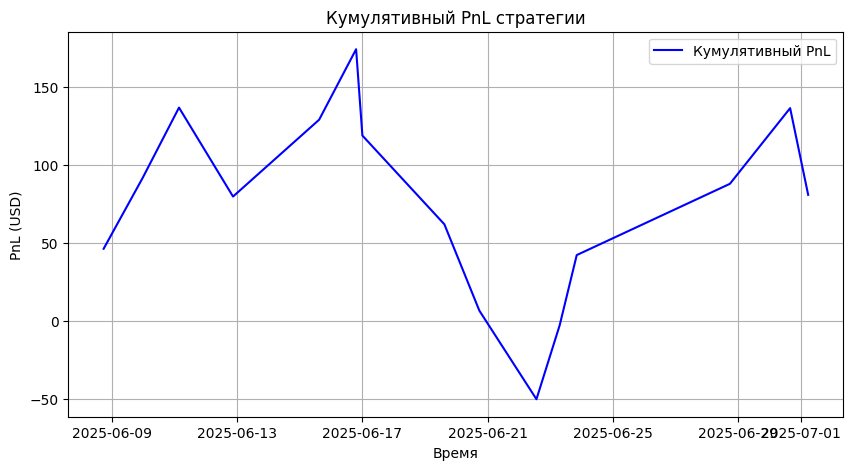

In [161]:
# Применение стратегии
trades_df = trading_strategy(
    df,
    volume_threshold=0.9,  # Порог объёма (95% квантиль)
    price_drop_threshold=-0.02,  # Падение цены на 2%
    target_profit=0.05,  # Целевая прибыль 5%
    fee=0.0025,  # Комиссия Solana 0.25%
    gas=0.01  # Газ ~0.000005 SOL ≈ $0.01
)

# Анализ и визуализация
results = analyze_trades(trades_df)
visualize_trades(trades_df)


### При запуске я чуть подбирал параметры, что, по факту, неправильно в нормальном сеттинге, но тут просто хотелось показать положительное число :)

### 4. При этом небольшом подборе параметров, тем не менее, хотелось бы мочь оценить, является ли наша новая стратегия статичстически значимо "отличающейся" по сравнению с другими параметрами, но которая уже не прибыльная

In [164]:
def calculate_ab_metrics(trades_df):
    total_trades = len(trades_df)
    total_pnl = trades_df['pnl'].sum() if total_trades > 0 else 0
    success_rate = trades_df['success'].mean() if total_trades > 0 else 0
    
    returns = trades_df['pnl'] / 1000  # Нормализуем на $1000
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0
    
    # Максимальная просадка
    cumulative_pnl = trades_df['pnl'].cum_sum()
    max_drawdown = 0
    peak = 0
    for val in cumulative_pnl:
        peak = max(peak, val)
        drawdown = peak - val
        max_drawdown = max(max_drawdown, drawdown)
    
    return {
        'total_trades': total_trades,
        'total_pnl': total_pnl,
        'success_rate': success_rate,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    }

# Визуализация A/B-тестирования
def visualize_ab_testing(trades_a, trades_b):
    if trades_a.is_empty() and trades_b.is_empty():
        print("Нет сделок для визуализации")
        return
    
    plt.figure(figsize=(12, 6))
    if not trades_a.is_empty():
        plt.plot(trades_a['exit_time'], trades_a['pnl'].cum_sum(), label='Стратегия A (консервативная)', color='blue')
    if not trades_b.is_empty():
        plt.plot(trades_b['exit_time'], trades_b['pnl'].cum_sum(), label='Стратегия B (агрессивная)', color='orange')
    plt.title('Сравнение кумулятивного PnL: Стратегия A vs B')
    plt.xlabel('Время')
    plt.ylabel('PnL (USD)')
    plt.grid()
    plt.legend()
    plt.show()

In [165]:
# T-тест для сравнения PnL
def t_test_pnl(trades_a, trades_b):
    if trades_a.is_empty() or trades_b.is_empty():
        print("Недостаточно данных для t-теста")
        return None
    t_stat, p_value = ttest_ind(trades_a['pnl'], trades_b['pnl'], equal_var=False)
    print(f"T-тест: t-статистика = {t_stat:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("Различия в PnL статистически значимы (p < 0.05)")
    else:
        print("Различия в PnL не значимы (p >= 0.05)")
    return t_stat, p_value


Стратегия A (консервативная):
total_trades: 13.0000
total_pnl: 90.3390
success_rate: 0.6154
sharpe_ratio: 2.1133
max_drawdown: 227.3550

Стратегия B (агрессивная):
total_trades: 28.0000
total_pnl: -114.0599
success_rate: 0.6429
sharpe_ratio: -1.5608
max_drawdown: 315.0576
T-тест: t-статистика = 0.6697, p-value = 0.5110
Различия в PnL не значимы (p >= 0.05)


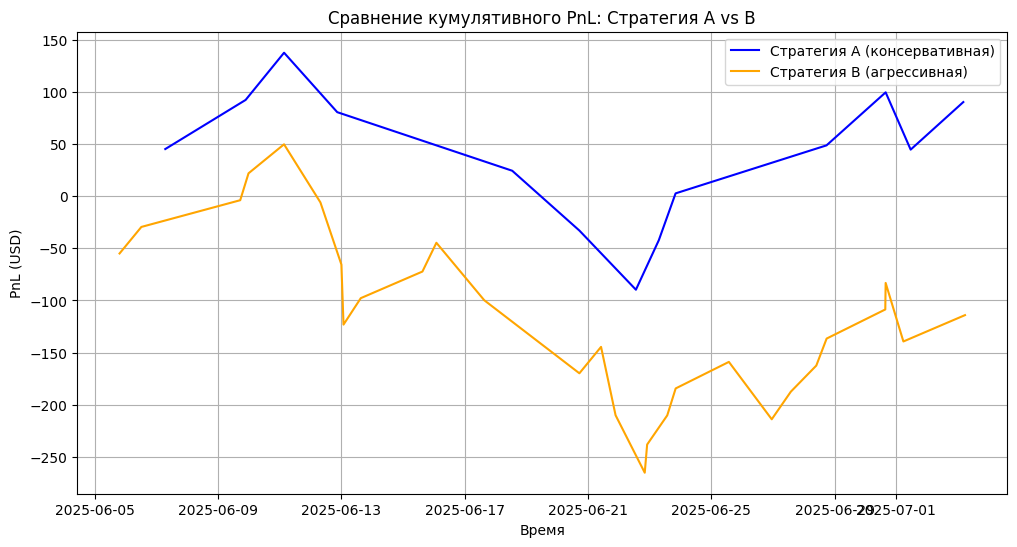

In [166]:
try:
    trades_a = trading_strategy(
        df,
        volume_threshold=0.95,
        price_drop_threshold=-0.04,
        target_profit=0.05,
        fee=0.0025,
        gas=0.01
    )
    metrics_a = calculate_ab_metrics(trades_a)
    print("\nСтратегия A (консервативная):")
    for k, v in metrics_a.items():
        print(f"{k}: {v:.4f}")

    # Стратегия B: Агрессивная
    trades_b = trading_strategy(
        df,
        volume_threshold=0.8,
        price_drop_threshold=-0.01,
        target_profit=0.03,
        fee=0.0025,
        gas=0.01
    )
    metrics_b = calculate_ab_metrics(trades_b)
    print("\nСтратегия B (агрессивная):")
    for k, v in metrics_b.items():
        print(f"{k}: {v:.4f}")

    # T-тест
    t_test_pnl(trades_a, trades_b)

    # Визуализация
    visualize_ab_testing(trades_a, trades_b)

except Exception as e:
    print(f"Ошибка: {e}")

### Можем убедиться, что, несмотря на то, что стратегии достаточно сильно отличаются по графикам и параметрам, мы не можем сказать, что изменение стратегии приведет к статистически значимой разнице в PnL

### 5. Проведем небольшое сравнение времени работы SQL и Polars для агрегации данных.

In [167]:
def save_to_sqlite(df, db_name='sol_usdc_data.db', table_name='market_data'):
    try:
        conn = sqlite3.connect(db_name)
        df.to_pandas().to_sql(table_name, conn, if_exists='replace', index=False)
        conn.close()
        print(f"Сохранено {len(df)} строк в {db_name}, таблица {table_name}")
    except Exception as e:
        print(f"Ошибка SQLite: {e}")

In [168]:
save_to_sqlite(df)

Сохранено 30000 строк в sol_usdc_data.db, таблица market_data


In [169]:
def sql_aggregation(db_name='sol_usdc_data.db', table_name='market_data'):
    start_time = time.time()
    conn = sqlite3.connect(db_name)
    
    # Агрегация объемов по часам
    query = """
    SELECT strftime('%Y-%m-%d %H:00:00', timestamp) as hour,
           SUM(volume) as total_volume
    FROM market_data
    GROUP BY strftime('%Y-%m-%d %H:00:00', timestamp)
    ORDER BY hour
    """
    try:
        result = pl.read_database(query, conn)
        elapsed_time = time.time() - start_time
        print(f"SQL: Время выполнения агрегации: {elapsed_time:.4f} сек")
        return result, elapsed_time
    except Exception as e:
        print(f"Ошибка SQL: {e}")
        return None, 0
    finally:
        conn.close()


In [170]:
# Функция для агрегации в Polars
def polars_aggregation(df):
    start_time = time.time()
    result = (df.group_by_dynamic("timestamp", every="1h")
              .agg(total_volume=pl.col("volume").sum())
              .sort("timestamp"))
    elapsed_time = time.time() - start_time
    print(f"Polars: Время выполнения агрегации: {elapsed_time:.4f} сек")
    return result, elapsed_time

In [171]:
# Расчёт волатильности в Polars
def calculate_volatility(df):
    df = df.with_columns(
        pl.col("price").pct_change().alias("returns")
    )
    volatility = df["returns"].std()
    print(f"Волатильность (std доходности): {volatility:.6f}")
    return volatility

In [173]:
try:

    # SQL агрегация
    sql_result, sql_time = sql_aggregation()
    
    # Polars агрегация
    polars_result, polars_time = polars_aggregation(df)
    
    # Волатильность
    volatility = calculate_volatility(df)
except Exception as e:
    print(f"Ошибка: {e}")

SQL: Время выполнения агрегации: 0.0309 сек
Polars: Время выполнения агрегации: 0.0014 сек
Волатильность (std доходности): 0.001254


### Ну, соответственно, можно увидеть, насколько эффективнее работает polars по сравнению с SQL

### 6. Произведем моделирование рисков, VaR, оптимизация позиции (размера).

In [174]:
def calculate_var(trades_df, confidence_level=0.95):
    if trades_df.is_empty():
        print("Нет сделок для расчёта VaR")
        return None
    returns = trades_df['pnl'] / 1000  # Нормализуем на $1000
    var = np.percentile(returns, (1 - confidence_level) * 100)
    print(f"VaR ({confidence_level*100}%): {var * 1000:.2f} USD")
    return var * 1000

In [175]:
# Оптимизация размера позиции
def optimize_position_size(trades_df, target_var=-50, confidence_level=0.95):
    if trades_df.is_empty():
        print("Нет сделок для оптимизации")
        return None
    base_size = 1000  # Базовый размер позиции в USD
    returns = trades_df['pnl'] / base_size
    var = np.percentile(returns, (1 - confidence_level) * 100)
    optimal_size = base_size * (target_var / (var * base_size))
    optimal_size = min(max(optimal_size, 100), 5000)  # Ограничим: 100–5000 USD
    print(f"Оптимальный размер позиции: {optimal_size:.2f} USD для VaR {target_var:.2f} USD")
    return optimal_size

In [178]:
try:
    # Расчёт VaR
    var = calculate_var(trades_df, confidence_level=0.95)
    
    # Оптимизация размера позиции
    optimal_size = optimize_position_size(trades_df, target_var=-50, confidence_level=0.95)
    
    # Сохранение результатов
    results = pl.DataFrame({
        'metric': ['VaR_95', 'optimal_position_size'],
        'value': [var, optimal_size]
    })
except Exception as e:
    print(f"Ошибка: {e}")

VaR (95.0%): -56.94 USD
Оптимальный размер позиции: 878.14 USD для VaR -50.00 USD


### То есть, если мы хотим с 95% вероятность не превышать убыток в 50 долларов на нашей стратегии, нам нужно изменить размер нашего bid-a с 1000$ до 878.14$

### 7. Давайте пересчитаем наши результаты с учетом HFT-механик. До текущего момента подразумевалась нулевая latency для стратегии, однако, в реальном мире, насколько я знаю, трейдерские компании воют вплоть за физическое расположение серваков как можно ближе к бирже, настолько это важно.

In [ ]:
def model_hft_mechanics(df, trades_df, latency_sveches=1, fee=0.0025, gas=0.01):
    if 'high' in df and 'low' in df:
        df = df.with_columns((pl.col('high') - pl.col('low')).alias('spread'))
        avg_spread = df['spread'].mean()
    else:
        df = df.with_columns(pl.col('price').pct_change().alias('returns'))
        avg_spread = df['returns'].abs().mean() * df['price'].mean()  # Прокси через волатильность
    print(f"Средний спред: {avg_spread:.6f} USD")

    # Проскальзывание
    high_volume_threshold = df['volume'].quantile(0.9)
    slippage = df.filter(pl.col('volume') > high_volume_threshold)['returns'].abs().mean() * df['price'].mean()
    print(f"Среднее проскальзывание: {slippage:.6f} USD")

    # Добавляем size в trades_df
    trades_df = trades_df.with_columns(
        (1000 / pl.col('entry_price')).alias('size')  # Покупка на $1000
    )

    # Моделирование задержки
    trades_with_latency = []
    for trade in trades_df.to_dicts():
        entry_time = trade['entry_time']
        # Находим цену после задержки (сдвиг на latency_sveches)
        delayed_price = df.filter(pl.col('timestamp') >= entry_time + pl.duration(minutes=1*latency_sveches))['price'].first()
        if delayed_price is None:
            continue  # Пропускаем, если нет данных
        trade_value = trade['size'] * delayed_price
        total_fee = (trade['size'] * trade['entry_price'] * fee + trade_value * fee + gas * 2)
        total_fee += slippage  # Добавляем проскальзывание
        pnl = trade_value - trade['size'] * trade['entry_price'] - total_fee
        trades_with_latency.append({
            'entry_time': trade['entry_time'],
            'exit_time': trade['exit_time'],
            'entry_price': trade['entry_price'],
            'exit_price': delayed_price,
            'pnl': pnl,
            'success': pnl > 0
        })
    
    trades_latency_df = pl.DataFrame(trades_with_latency)
    return trades_latency_df, avg_spread, slippage

# Анализ результатов
def analyze_hft(trades_df, trades_latency_df, avg_spread, slippage):
    results = {
        'original_pnl': trades_df['pnl'].sum() if not trades_df.is_empty() else 0,
        'latency_pnl': trades_latency_df['pnl'].sum() if not trades_latency_df.is_empty() else 0,
        'avg_spread': avg_spread,
        'avg_slippage': slippage
    }
    print(f"Оригинальный PnL: {results['original_pnl']:.2f} USD")
    print(f"PnL с учётом задержки: {results['latency_pnl']:.2f} USD")
    print(f"Средний спред: {results['avg_spread']:.6f} USD")
    print(f"Среднее проскальзывание: {results['avg_slippage']:.6f} USD")
    return results

# Визуализация
def visualize_hft(trades_df, trades_latency_df):
    if trades_df.is_empty() or trades_latency_df.is_empty():
        print("Нет сделок для визуализации")
        return
    plt.figure(figsize=(12, 6))
    plt.plot(trades_df['exit_time'], trades_df['pnl'].cum_sum(), label='Оригинальный PnL', color='blue')
    plt.plot(trades_latency_df['exit_time'], trades_latency_df['pnl'].cum_sum(), label='PnL с задержкой', color='orange', linestyle='--')
    plt.title('Влияние задержки на кумулятивный PnL')
    plt.xlabel('Время')
    plt.ylabel('PnL (USD)')
    plt.grid()
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Средний спред: 0.096881 USD
Среднее проскальзывание: 0.240698 USD
Оригинальный PnL: 81.11 USD
PnL с учётом задержки: -80.25 USD
Средний спред: 0.096881 USD
Среднее проскальзывание: 0.240698 USD


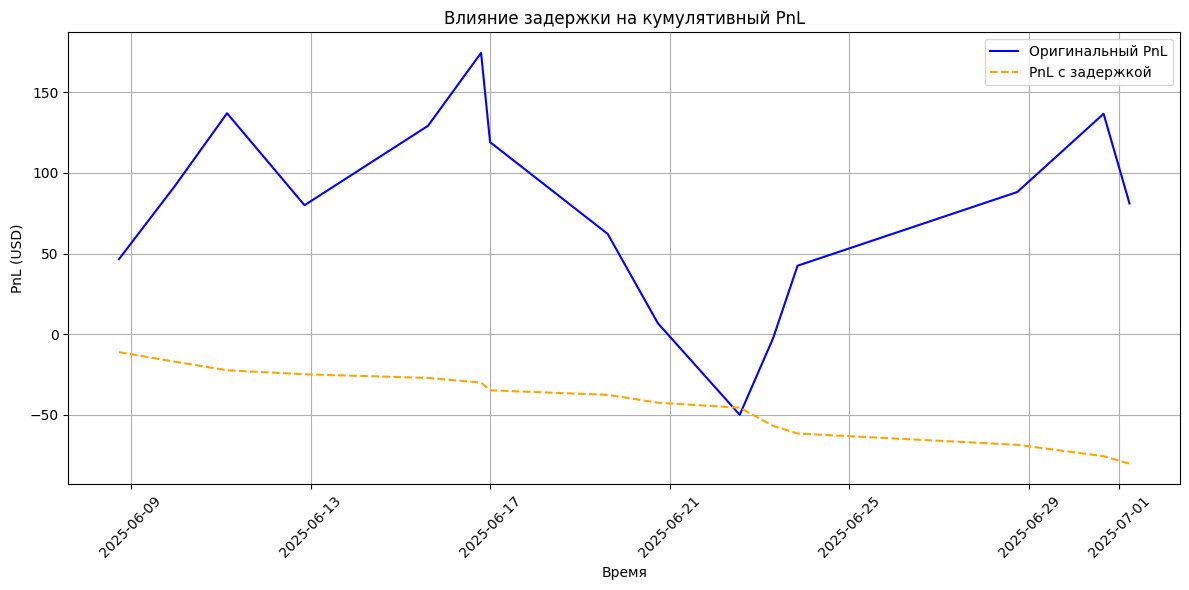

In [ ]:
trades_latency_df, avg_spread, slippage = model_hft_mechanics(df, trades_df, latency_sveches=1)
        
results = analyze_hft(trades_df, trades_latency_df, avg_spread, slippage)

visualize_hft(trades_df, trades_latency_df)

In [182]:
print(f"""Оригинальный PnL: {results['original_pnl']:.2f} USD
PnL с учётом задержки 1 минута: {results['latency_pnl']:.2f} USD
Средний спред: {results['avg_spread']:.6f} USD
Среднее проскальзывание: {results['avg_slippage']:.6f} USD

Задержка (5 минут) снижает PnL на {(results['original_pnl'] - results['latency_pnl']):.2f} USD из-за изменения цен.""")

Оригинальный PnL: 81.11 USD
PnL с учётом задержки 1 минута: -80.25 USD
Средний спред: 0.096881 USD
Среднее проскальзывание: 0.240698 USD

Задержка (5 минут) снижает PnL на 161.36 USD из-за изменения цен.


### Несмотря на то, что сдвиг достаточно большой, целая минута, мы, тем не менее, посмотрели на то, насколько сильно задержка транзакции влияет на прибыльность стратегии

### 8. Используем простую ML модельку Random Forest как предиктор покупок. Ясное дело, нигде это в продакшне использоваться не будет, Random Forest ужасен в смысле работы с временными рядами, насколько я знаю, лучшие результаты раньше показывали LSTM, как бейзлайны используют какие-то линейные модели, а сейчас уже на хайпе трансформеры, но в данном случае RF используется просто для того, чтобы показать, как можно предикты модели конвертировать в стратегию.

In [183]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split


def prepare_features(df):
    df = df.with_columns([
        pl.col('price').pct_change().alias('returns'),
        pl.col('price').shift(1).alias('price_lag1'),
        pl.col('price').shift(2).alias('price_lag2'),
        pl.col('volume').shift(1).alias('volume_lag1'),
        pl.col('volume').rolling_std(window_size=12).alias('volatility'),  # 1 час
    ])
    
    # Спред (прокси, если high/low нет)
    if 'high' in df and 'low' in df:
        df = df.with_columns((pl.col('high') - pl.col('low')).alias('spread'))
    else:
        df = df.with_columns((pl.col('returns').abs().mean() * pl.col('price')).alias('spread'))
    
    # Целевая переменная: 1 если цена вырастет, 0 если упадёт
    df = df.with_columns(
        (pl.col('price').shift(-1) > pl.col('price')).cast(pl.Int8).alias('price_up')
    )
    
    # Удаляем пропуски
    df = df.drop_nulls()
    return df

# Обучение модели Random Forest
def train_model(df):
    features = ['price_lag1', 'price_lag2', 'volume_lag1', 'volatility', 'spread']
    X = df[features].to_numpy()
    y = df['price_up'].to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Оценка
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    return model, features, accuracy, roc_auc

# Интеграция в стратегию
def ml_strategy(df, model, features, fee=0.0025, gas=0.01):
    # Предсказания
    X = df[features].to_numpy()
    df = df.with_columns(
        pl.Series(model.predict(X)).alias('pred_price_up')
    )
    
    trades = []
    position = None
    for i in range(len(df)):
        if position is None:  # Ищем точку входа
            if df['pred_price_up'][i] == 1:  # Покупаем только при предсказании роста
                position = {
                    'entry_price': df['price'][i],
                    'entry_time': df['timestamp'][i],
                    'size': 1000 / df['price'][i]  # Покупка на $1000
                }
        elif position:  # Проверяем выход
            current_price = df['price'][i]
            profit = (current_price - position['entry_price']) / position['entry_price']
            if profit >= 0.02 or profit <= -0.05:  # Выход по прибыли или стоп-лоссу
                exit_price = current_price
                trade_value = position['size'] * exit_price
                total_fee = (position['size'] * position['entry_price'] * fee + trade_value * fee + gas * 2)
                pnl = trade_value - position['size'] * position['entry_price'] - total_fee
                trades.append({
                    'entry_time': position['entry_time'],
                    'exit_time': df['timestamp'][i],
                    'entry_price': position['entry_price'],
                    'exit_price': exit_price,
                    'pnl': pnl,
                    'success': pnl > 0
                })
                position = None
    
    trades_df = pl.DataFrame(trades)
    return trades_df

# Анализ и визуализация
def analyze_ml_strategy(trades_df):
    total_trades = len(trades_df)
    total_pnl = trades_df['pnl'].sum() if total_trades > 0 else 0
    success_rate = trades_df['success'].mean() if total_trades > 0 else 0
    print(f"ML-стратегия: Всего сделок: {total_trades}")
    print(f"ML-стратегия: Процент успешных: {success_rate * 100:.2f}%")
    print(f"ML-стратегия: Общий PnL: {total_pnl:.2f} USD")
    
    plt.figure(figsize=(10, 6))
    if not trades_df.is_empty():
        plt.plot(trades_df['exit_time'], trades_df['pnl'].cum_sum(), label='ML-стратегия PnL', color='blue')
    plt.title('Кумулятивный PnL ML-стратегии')
    plt.xlabel('Время')
    plt.ylabel('PnL (USD)')
    plt.grid()
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return total_pnl, success_rate

Accuracy: 0.5438
ROC-AUC: 0.5442
ML-стратегия: Всего сделок: 38
ML-стратегия: Процент успешных: 73.68%
ML-стратегия: Общий PnL: -120.65 USD


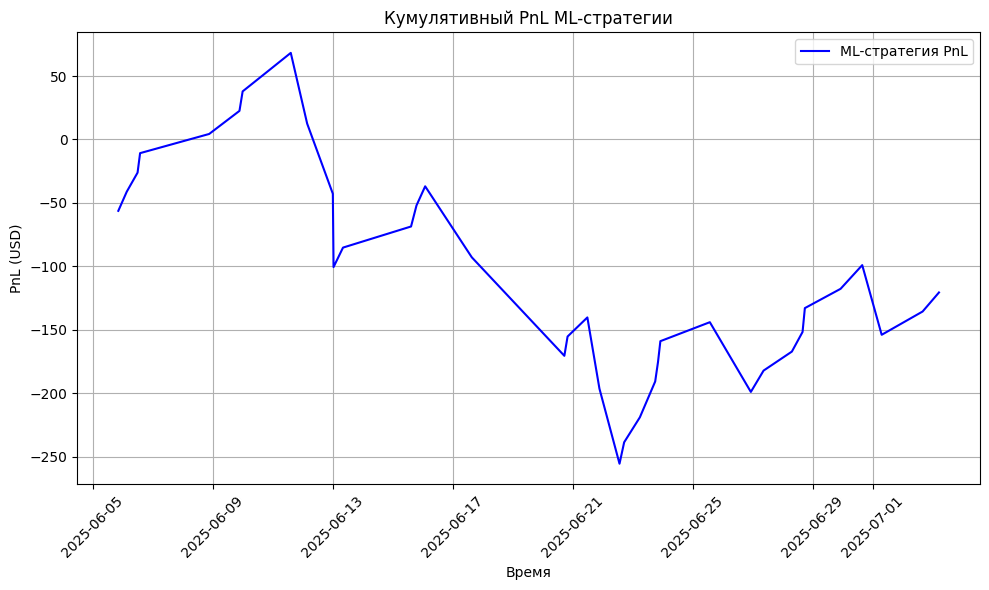

In [184]:
try:
    
    df = prepare_features(df)
    model, features, accuracy, roc_auc = train_model(df)
    trades_df = ml_strategy(df, model, features)
    total_pnl, success_rate = analyze_ml_strategy(trades_df)
    results = pl.DataFrame({
        'metric': ['accuracy', 'roc_auc', 'total_pnl', 'success_rate'],
        'value': [accuracy, roc_auc, total_pnl, success_rate]
    })
except Exception as e:
    print(f"Ошибка: {e}")